In [7]:
from IPython.display import Image

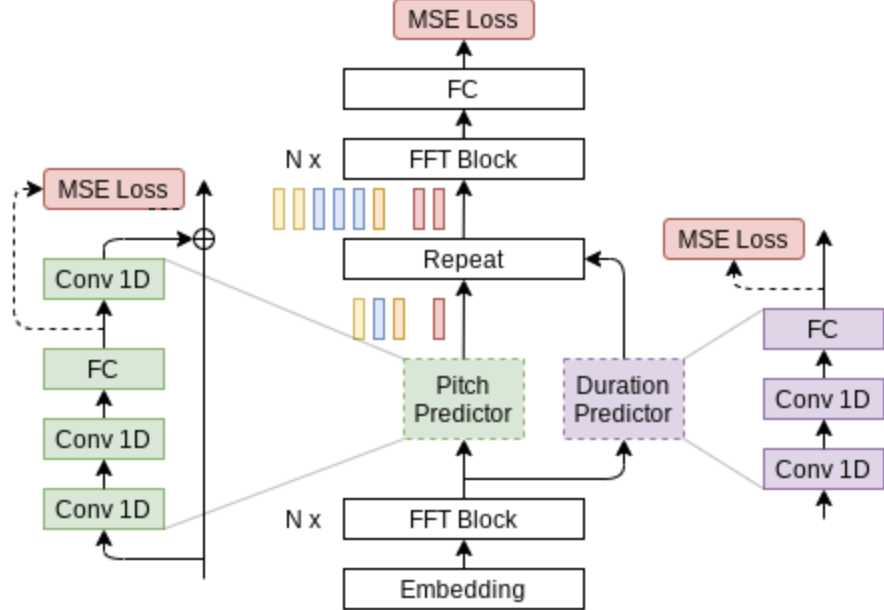

In [16]:
Image(filename = "../references/images/fastpitch_model.png", width=800, height=500)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Transformer

In [10]:
class PositionalEmbedding(nn.Module):
    def __init__(self, demb):
        super(PositionalEmbedding, self).__init__()
        self.demb = demb
        inv_freq = 1 / (10000 ** (torch.arange(0.0, demb, 2.0) / demb))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, pos_seq, bsz=None):
        sinusoid_inp = torch.matmul(torch.unsqueeze(pos_seq, -1),
                                    torch.unsqueeze(self.inv_freq, 0))
        pos_emb = torch.cat([sinusoid_inp.sin(), sinusoid_inp.cos()], dim=1)
        if bsz is not None:
            return pos_emb[None, :, :].expand(bsz, -1, -1)
        else:
            return pos_emb[None, :, :]

In [11]:
class PositionwiseConvFF(nn.Module):
    def __init__(self, d_model, d_inner, kernel_size, dropout, pre_lnorm=False):
        super(PositionwiseConvFF, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner
        self.dropout = dropout

        self.CoreNet = nn.Sequential(
            nn.Conv1d(d_model, d_inner, kernel_size, 1, (kernel_size // 2)),
            nn.ReLU(),
            # nn.Dropout(dropout),  # worse convergence
            nn.Conv1d(d_inner, d_model, kernel_size, 1, (kernel_size // 2)),
            nn.Dropout(dropout),
        )
        self.layer_norm = nn.LayerNorm(d_model)
        self.pre_lnorm = pre_lnorm

    def forward(self, inp):
        return self._forward(inp)

    def _forward(self, inp):
        if self.pre_lnorm:
            # layer normalization + positionwise feed-forward
            core_out = inp.transpose(1, 2)
            core_out = self.CoreNet(self.layer_norm(core_out).to(inp.dtype))
            core_out = core_out.transpose(1, 2)

            # residual connection
            output = core_out + inp
        else:
            # positionwise feed-forward
            core_out = inp.transpose(1, 2)
            core_out = self.CoreNet(core_out)
            core_out = core_out.transpose(1, 2)

            # residual connection + layer normalization
            output = self.layer_norm(inp + core_out).to(inp.dtype)

        return output

In [12]:
class MultiHeadAttn(nn.Module):
    def __init__(self, n_head, d_model, d_head, dropout, dropatt=0.1,
                 pre_lnorm=False):
        super(MultiHeadAttn, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_head = d_head
        self.scale = 1 / (d_head ** 0.5)
        self.pre_lnorm = pre_lnorm

        self.qkv_net = nn.Linear(d_model, 3 * n_head * d_head)
        self.drop = nn.Dropout(dropout)
        self.dropatt = nn.Dropout(dropatt)
        self.o_net = nn.Linear(n_head * d_head, d_model, bias=False)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inp, attn_mask=None):
        return self._forward(inp, attn_mask)

    def _forward(self, inp, attn_mask=None):
        residual = inp

        if self.pre_lnorm:
            # layer normalization
            inp = self.layer_norm(inp)

        n_head, d_head = self.n_head, self.d_head

        head_q, head_k, head_v = torch.chunk(self.qkv_net(inp), 3, dim=2)
        head_q = head_q.view(inp.size(0), inp.size(1), n_head, d_head)
        head_k = head_k.view(inp.size(0), inp.size(1), n_head, d_head)
        head_v = head_v.view(inp.size(0), inp.size(1), n_head, d_head)

        q = head_q.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)
        k = head_k.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)
        v = head_v.permute(2, 0, 1, 3).reshape(-1, inp.size(1), d_head)

        attn_score = torch.bmm(q, k.transpose(1, 2))
        attn_score.mul_(self.scale)

        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(1).to(attn_score.dtype)
            attn_mask = attn_mask.repeat(n_head, attn_mask.size(2), 1)
            attn_score.masked_fill_(attn_mask.to(torch.bool), -float('inf'))

        attn_prob = F.softmax(attn_score, dim=2)
        attn_prob = self.dropatt(attn_prob)
        attn_vec = torch.bmm(attn_prob, v)

        attn_vec = attn_vec.view(n_head, inp.size(0), inp.size(1), d_head)
        attn_vec = attn_vec.permute(1, 2, 0, 3).contiguous().view(
            inp.size(0), inp.size(1), n_head * d_head)

        # linear projection
        attn_out = self.o_net(attn_vec)
        attn_out = self.drop(attn_out)

        if self.pre_lnorm:
            # residual connection
            output = residual + attn_out
        else:
            # residual connection + layer normalization
            output = self.layer_norm(residual + attn_out)

        output = output.to(attn_out.dtype)

        return output

In [13]:
class TransformerLayer(nn.Module):
    def __init__(self, n_head, d_model, d_head, d_inner, kernel_size, dropout,
                 **kwargs):
        super(TransformerLayer, self).__init__()

        self.dec_attn = MultiHeadAttn(n_head, d_model, d_head, dropout, **kwargs)
        self.pos_ff = PositionwiseConvFF(d_model, d_inner, kernel_size, dropout,
                                         pre_lnorm=kwargs.get('pre_lnorm'))

    def forward(self, dec_inp, mask=None):
        output = self.dec_attn(dec_inp, attn_mask=~mask.squeeze(2))
        output *= mask
        output = self.pos_ff(output)
        output *= mask
        return output

In [14]:
class FFTransformer(nn.Module):
    def __init__(self, n_layer, n_head, d_model, d_head, d_inner, kernel_size,
                 dropout, dropatt, dropemb=0.0, embed_input=True,
                 n_embed=None, d_embed=None, padding_idx=0, pre_lnorm=False):
        super(FFTransformer, self).__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.d_head = d_head
        self.padding_idx = padding_idx

        if embed_input:
            self.word_emb = nn.Embedding(n_embed, d_embed or d_model,
                                         padding_idx=self.padding_idx)
        else:
            self.word_emb = None

        self.pos_emb = PositionalEmbedding(self.d_model)
        self.drop = nn.Dropout(dropemb)
        self.layers = nn.ModuleList()

        for _ in range(n_layer):
            self.layers.append(
                TransformerLayer(
                    n_head, d_model, d_head, d_inner, kernel_size, dropout,
                    dropatt=dropatt, pre_lnorm=pre_lnorm)
            )

    def forward(self, dec_inp, seq_lens=None, conditioning=0):
        if self.word_emb is None:
            inp = dec_inp
            mask = mask_from_lens(seq_lens).unsqueeze(2)
        else:
            inp = self.word_emb(dec_inp)
            # [bsz x L x 1]
            mask = (dec_inp != self.padding_idx).unsqueeze(2)

        pos_seq = torch.arange(inp.size(1), device=inp.device).to(inp.dtype)
        pos_emb = self.pos_emb(pos_seq) * mask

        out = self.drop(inp + pos_emb + conditioning)

        for layer in self.layers:
            out = layer(out, mask=mask)

        # out = self.drop(out)
        return out, mask